In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import h5py
from IPython.display import display
import numpy as np
from os.path import join as pj
from os import getcwd as cwd
import pandas as pd
import random
import sys
import torch
import torch.nn as nn
from tqdm import tqdm
import visdom

# Logger
from IO.logger import Logger
# Data Augument
from dataset.classification.loader import create_validation_split, load_validation_data, create_train_data
# Data Sampling
from dataset.classification.sampler import get_randomsampled_idx, get_randomoversampled_idx
# Model
from model.resnet.resnet import ResNet
from model.resnet.utils import define_weight
from model.resnet.predict import test_classification
from model.optimizer import AdamW
# Evaluation
from evaluation.classification.evaluate import accuracy, confusion_matrix
# Statistics
from evaluation.classification.statistics import compute_each_size_df, compute_all_size_df
# Visualize
from evaluation.classification.visualize import create_confusion_matrix, plot_df_distrib_size

# Train Config

In [3]:
class args:
    # experiment_name
    experiment_name = "resnet50_b20_r45_lr1e-5_crossvalid_randomsampling"
    # data split
    train_ratio = 0.8 # unused parameters
    test_ratio = 0.2
    # paths
    all_data_path = pj(cwd(), "data/all_classification_data/classify_insect_std")
    model_root = pj(cwd(), "output_model/classification/ResNet101", experiment_name)
    figure_root = pj(cwd(), "figure/classification/ResNet101", experiment_name)
    # train config
    model_name = "resnet50" # choice ["resnet18", "resnet34", "resnet50", "resnet101", "resnet152"]
    bs = 20
    lr = 1e-5
    lamda = 1e-2
    nepoch = 40
    rotate = 45
    pretrain = True
    param_freeze = False
    correction_term = False
    sampling = "RandomSample" # choice [None, "RandomSample", "RandomOverSample"]
    augment = None # choice [None, "RandomSizeCrop", "RegionConfusionMechanism"]
    optimizer = "AdamW" # choice ["Adam, AdamW"]
    activation_function = "ReLU" # choice ["ReLU", "LeakyReLU", "RReLU"]
    # test config
    save_fig = True
    save_df = True
    # visdom
    visdom = True
    port = 8097

In [4]:
dataset_name = args.all_data_path.split('/')[-1]
if dataset_name == 'classify_insect_std':
    args.labels =  ['Diptera', 'Ephemeridae', 'Ephemeroptera', 
                    'Lepidoptera', 'Plecoptera', 'Trichoptera']
elif dataset_name == 'classify_insect_resize_std':
    args.labels =  ['Diptera', 'Ephemeridae', 'Ephemeroptera', 
                    'Lepidoptera', 'Plecoptera', 'Trichoptera']
elif dataset_name == 'classify_insect_std_resize':
    args.labels =  ['Diptera', 'Ephemeridae', 'Ephemeroptera', 
                    'Lepidoptera', 'Plecoptera', 'Trichoptera']

# Train

In [5]:
def train(model, xtr, ytr, bs=20, lr=1e-5, nepoch=40, visdom=False):
    # calculate counts and count_sum
    _, counts = np.unique(ytr, return_counts=True)
    counts_sum = counts.sum()
    
    # define weight and create loss function
    ce = torch.nn.CrossEntropyLoss(define_weight(counts))
    l2_loss = nn.MSELoss(reduction='elementwise_mean').cuda()
    
    # define optimizer
    if args.optimizer == "Adam":
        opt = torch.optim.Adam(model.parameters(), lr=lr)
    elif args.optimizer == "AdamW":
        opt = AdamW(model.parameters(), lr=lr)
    
    # set model train mode
    model.train()
    
    t = tqdm(range(nepoch),leave=False)
    # training
    for epoch in t:
        sum_cls_loss = 0
        sum_norm_loss = 0
        total_loss = 0
        index = random.sample(range(counts_sum),counts_sum)
        t.set_description("epoch=%s" % (epoch))
        for idx in range(0,counts_sum-bs,bs):
            idx = index[idx:idx+bs]
            x = xtr[idx].cuda()
            y = ytr[idx].cuda()
            opt.zero_grad()
            out = model(x)
            cls_loss = ce(out, y)
            if args.lamda != 0:
                norm_loss = 0
                for param in model.parameters():
                    param_target = torch.zeros(param.size()).cuda()
                    norm_loss += l2_loss(param, param_target)

                norm_loss = norm_loss * args.lamda
            else:
                norm_loss = 0
            sum_cls_loss += cls_loss.item()
            sum_norm_loss += norm_loss.item()
            loss = cls_loss + norm_loss
            total_loss += loss.item()
            loss.backward()
            opt.step()
            sys.stdout.write("\rcls_loss=%f, norm_loss=%f" % (cls_loss.item(), norm_loss.item()))
            sys.stdout.flush()
        
        model.training = False
        if args.correction_term == True:
            te_acc, correction_term = accuracy(model, xte, yte, bs, return_correction_term=True, low_trainable_correction=True)
            ce = torch.nn.CrossEntropyLoss(define_weight(counts) * correction_term)
            print(correction_term)
        else:
            te_acc = accuracy(model, xte, yte, bs)
        model.training = True
        if visdom:
            visualize(vis, epoch+1, sum_cls_loss, win_cls_loss)
            visualize(vis, epoch+1, sum_norm_loss, win_norm_loss)
            visualize(vis, epoch+1, total_loss, win_train_loss)
            visualize(vis, epoch+1, te_acc, win_test_acc)
        print("sum_cls_loss=%f, sum_norm_loss=%f, total_loss=%f, te_acc=%f" % (sum_cls_loss, sum_norm_loss, total_loss, te_acc))

# Set Visdom

In [6]:
if args.visdom:
    # Create visdom
    vis = visdom.Visdom(port=args.port)
    
    win_cls_loss = vis.line(
        X=np.array([0]),
        Y=np.array([0]),
        opts=dict(
            title='cls_loss',
            xlabel='epoch',
            ylabel='loss',
            width=800,
            height=400
        )
    )
    win_norm_loss = vis.line(
        X=np.array([0]),
        Y=np.array([0]),
        opts=dict(
            title='norm_loss',
            xlabel='epoch',
            ylabel='loss',
            width=800,
            height=400
        )
    )
    win_train_loss = vis.line(
        X=np.array([0]),
        Y=np.array([0]),
        opts=dict(
            title='train_loss',
            xlabel='epoch',
            ylabel='loss',
            width=800,
            height=400
        )
    )
    win_test_acc = vis.line(
        X=np.array([0]),
        Y=np.array([0]),
        opts=dict(
            title='test_accuracy',
            xlabel='epoch',
            ylabel='loss',
            width=800,
            height=400
        )
    )

Setting up a new session...


In [7]:
def visualize(vis, phase, visualized_data, window):
    vis.line(
        X=np.array([phase]),
        Y=np.array([visualized_data]),
        update='append',
        win=window
    )

### Save args

In [8]:
args_logger = Logger(args)
args_logger.save()

# Cross Validation

In [9]:
model_save_path = pj(args.model_root, "final.pth")
if os.path.exists(args.model_root) is False:
    os.makedirs(args.model_root)
if os.path.exists(args.figure_root) is False:
    os.makedirs(args.figure_root)

In [10]:
def adopt_sampling(sampling, Y, idx):
    if sampling == "RandomSample":
        print("sampling = RandomSample")
        new_train_idx = get_randomsampled_idx(Y, idx)
    elif sampling == "RandomOverSample":
        print("sampling == RandomOverSample")
        new_train_idx = get_randomoversampled_idx(Y, idx)
    else:
        print("sampling = None")
        new_train_idx = idx
    return new_train_idx

In [11]:
valid_num = int(1.0/args.test_ratio)
with h5py.File(args.all_data_path) as f:
    X = f["X"][:]
    Y = f["Y"][:]
_, ntests = np.unique(Y, return_counts=True)
train_idxs, test_idxs = create_validation_split(Y, args.test_ratio)
result = []
for valid_count in range(valid_num):
    new_train_idx = adopt_sampling(args.sampling, Y, train_idxs[valid_count])
    xtr, ytr, xte, yte = load_validation_data(X, Y, new_train_idx, test_idxs[valid_count])
    xtr, ytr = create_train_data(xtr, ytr, args.rotate, args.augment)
    
    model = ResNet(args.model_name, len(args.labels), pretrain=args.pretrain, training=True, param_freeze=args.param_freeze, activation_function=args.activation_function).cuda()
    train(model, xtr, ytr, bs=args.bs, lr=args.lr, nepoch=args.nepoch, visdom=args.visdom)
    torch.save(model.state_dict(), model_save_path)
    
    model.training = False
    matrix = confusion_matrix(model, xte, yte, args.labels, bs=args.bs)
    model.training = True
    df = pd.DataFrame(matrix)
    display(df)
    if valid_count == 0:
        validation_matrix = matrix
        x_all = xte.cpu().numpy()
        y_all = yte.cpu().numpy()
    else:
        validation_matrix += matrix
        x_all = np.concatenate([x_all, xte.cpu().numpy()])
        y_all = np.concatenate([y_all, yte.cpu().numpy()])
    
    result.extend(test_classification(model, xte))

sampling = RandomSample


  0%|          | 0/246 [00:00<?, ?it/s]

augment = None
making rotate45 dataset


epoch=0:   0%|          | 0/40 [00:00<?, ?it/s]  

cls_loss=1.188554, norm_loss=0.031138

epoch=1:   2%|▎         | 1/40 [00:14<09:24, 14.48s/it]

sum_cls_loss=141.913733, sum_norm_loss=3.051560, total_loss=144.965293, te_acc=0.583658
cls_loss=0.683599, norm_loss=0.031139

epoch=2:   5%|▌         | 2/40 [00:28<09:08, 14.44s/it]

sum_cls_loss=90.994742, sum_norm_loss=3.051547, total_loss=94.046289, te_acc=0.688716
cls_loss=0.741455, norm_loss=0.031139

epoch=3:   8%|▊         | 3/40 [00:43<08:53, 14.42s/it]

sum_cls_loss=58.065083, sum_norm_loss=3.051633, total_loss=61.116715, te_acc=0.770428
cls_loss=0.256064, norm_loss=0.031140

epoch=4:  10%|█         | 4/40 [00:57<08:38, 14.41s/it]

sum_cls_loss=33.834556, sum_norm_loss=3.051697, total_loss=36.886253, te_acc=0.758755
cls_loss=0.109543, norm_loss=0.031141

epoch=5:  12%|█▎        | 5/40 [01:11<08:22, 14.37s/it]

sum_cls_loss=22.720577, sum_norm_loss=3.051760, total_loss=25.772337, te_acc=0.774319
cls_loss=0.063408, norm_loss=0.031141

epoch=6:  15%|█▌        | 6/40 [01:26<08:10, 14.44s/it]

sum_cls_loss=14.350658, sum_norm_loss=3.051784, total_loss=17.402442, te_acc=0.774319
cls_loss=0.149793, norm_loss=0.031141

epoch=7:  18%|█▊        | 7/40 [01:41<07:58, 14.49s/it]

sum_cls_loss=11.578349, sum_norm_loss=3.051796, total_loss=14.630145, te_acc=0.778210
cls_loss=0.299272, norm_loss=0.031140

epoch=8:  20%|██        | 8/40 [01:55<07:44, 14.53s/it]

sum_cls_loss=11.052785, sum_norm_loss=3.051755, total_loss=14.104540, te_acc=0.770428
cls_loss=0.030923, norm_loss=0.031140

epoch=9:  22%|██▎       | 9/40 [02:10<07:32, 14.61s/it]

sum_cls_loss=7.287210, sum_norm_loss=3.051714, total_loss=10.338925, te_acc=0.782101
cls_loss=0.007716, norm_loss=0.031139

epoch=10:  25%|██▌       | 10/40 [02:25<07:20, 14.67s/it]

sum_cls_loss=4.607414, sum_norm_loss=3.051646, total_loss=7.659060, te_acc=0.778210
cls_loss=0.055986, norm_loss=0.031138

epoch=11:  28%|██▊       | 11/40 [02:40<07:07, 14.75s/it]

sum_cls_loss=3.604079, sum_norm_loss=3.051572, total_loss=6.655651, te_acc=0.774319
cls_loss=0.014828, norm_loss=0.031137

epoch=12:  30%|███       | 12/40 [02:54<06:52, 14.75s/it]

sum_cls_loss=4.916408, sum_norm_loss=3.051486, total_loss=7.967894, te_acc=0.793774
cls_loss=0.047756, norm_loss=0.031136

epoch=13:  32%|███▎      | 13/40 [03:09<06:38, 14.76s/it]

sum_cls_loss=3.848430, sum_norm_loss=3.051385, total_loss=6.899815, te_acc=0.770428
cls_loss=0.013806, norm_loss=0.031135

epoch=14:  35%|███▌      | 14/40 [03:24<06:24, 14.80s/it]

sum_cls_loss=4.171352, sum_norm_loss=3.051272, total_loss=7.222624, te_acc=0.770428
cls_loss=0.009068, norm_loss=0.031134

epoch=15:  38%|███▊      | 15/40 [03:39<06:11, 14.86s/it]

sum_cls_loss=2.889148, sum_norm_loss=3.051157, total_loss=5.940305, te_acc=0.789883
cls_loss=0.021134, norm_loss=0.031133

epoch=16:  40%|████      | 16/40 [03:54<05:56, 14.85s/it]

sum_cls_loss=3.281925, sum_norm_loss=3.051044, total_loss=6.332969, te_acc=0.785992
cls_loss=0.007332, norm_loss=0.031131

epoch=17:  42%|████▎     | 17/40 [04:09<05:41, 14.84s/it]

sum_cls_loss=2.868714, sum_norm_loss=3.050931, total_loss=5.919646, te_acc=0.785992
cls_loss=0.011105, norm_loss=0.031130

epoch=18:  45%|████▌     | 18/40 [04:24<05:26, 14.86s/it]

sum_cls_loss=3.231309, sum_norm_loss=3.050809, total_loss=6.282118, te_acc=0.789883
cls_loss=0.022196, norm_loss=0.031129

epoch=19:  48%|████▊     | 19/40 [04:42<05:34, 15.95s/it]

sum_cls_loss=2.740904, sum_norm_loss=3.050694, total_loss=5.791598, te_acc=0.801556
cls_loss=0.009015, norm_loss=0.031128

epoch=20:  50%|█████     | 20/40 [05:12<06:39, 19.98s/it]

sum_cls_loss=1.580667, sum_norm_loss=3.050572, total_loss=4.631239, te_acc=0.797665
cls_loss=0.019340, norm_loss=0.031126

epoch=21:  52%|█████▎    | 21/40 [05:41<07:13, 22.81s/it]

sum_cls_loss=1.389614, sum_norm_loss=3.050428, total_loss=4.440042, te_acc=0.809339
cls_loss=0.005181, norm_loss=0.031124

epoch=22:  55%|█████▌    | 22/40 [06:10<07:23, 24.65s/it]

sum_cls_loss=1.734415, sum_norm_loss=3.050258, total_loss=4.784673, te_acc=0.809339
cls_loss=0.006423, norm_loss=0.031123

epoch=23:  57%|█████▊    | 23/40 [06:40<07:25, 26.23s/it]

sum_cls_loss=1.707715, sum_norm_loss=3.050106, total_loss=4.757821, te_acc=0.774319
cls_loss=0.068232, norm_loss=0.031121

epoch=24:  60%|██████    | 24/40 [07:10<07:16, 27.28s/it]

sum_cls_loss=2.821028, sum_norm_loss=3.049963, total_loss=5.870991, te_acc=0.782101
cls_loss=0.011376, norm_loss=0.031120

epoch=25:  62%|██████▎   | 25/40 [07:40<07:02, 28.17s/it]

sum_cls_loss=1.996860, sum_norm_loss=3.049819, total_loss=5.046680, te_acc=0.789883
cls_loss=0.006554, norm_loss=0.031118

epoch=26:  65%|██████▌   | 26/40 [08:10<06:42, 28.78s/it]

sum_cls_loss=2.512380, sum_norm_loss=3.049656, total_loss=5.562036, te_acc=0.801556
cls_loss=0.008406, norm_loss=0.031117

epoch=27:  68%|██████▊   | 27/40 [08:39<06:16, 28.95s/it]

sum_cls_loss=1.137715, sum_norm_loss=3.049503, total_loss=4.187219, te_acc=0.813230
cls_loss=0.006357, norm_loss=0.031115

epoch=28:  70%|███████   | 28/40 [09:08<05:46, 28.89s/it]

sum_cls_loss=0.951135, sum_norm_loss=3.049329, total_loss=4.000464, te_acc=0.813230
cls_loss=0.002178, norm_loss=0.031113

epoch=29:  72%|███████▎  | 29/40 [09:38<05:20, 29.14s/it]

sum_cls_loss=1.085096, sum_norm_loss=3.049144, total_loss=4.134240, te_acc=0.824903
cls_loss=0.001239, norm_loss=0.031111

epoch=30:  75%|███████▌  | 30/40 [10:07<04:51, 29.16s/it]

sum_cls_loss=1.253789, sum_norm_loss=3.048967, total_loss=4.302756, te_acc=0.809339
cls_loss=0.005142, norm_loss=0.031109

epoch=31:  78%|███████▊  | 31/40 [10:37<04:24, 29.44s/it]

sum_cls_loss=2.730470, sum_norm_loss=3.048787, total_loss=5.779256, te_acc=0.782101
cls_loss=0.002248, norm_loss=0.031107

epoch=32:  80%|████████  | 32/40 [11:07<03:55, 29.48s/it]

sum_cls_loss=0.650477, sum_norm_loss=3.048601, total_loss=3.699078, te_acc=0.797665
cls_loss=0.003195, norm_loss=0.031105

epoch=33:  82%|████████▎ | 33/40 [11:36<03:25, 29.39s/it]

sum_cls_loss=0.703225, sum_norm_loss=3.048403, total_loss=3.751628, te_acc=0.821012
cls_loss=0.001503, norm_loss=0.031103

epoch=34:  85%|████████▌ | 34/40 [12:05<02:55, 29.30s/it]

sum_cls_loss=0.685559, sum_norm_loss=3.048219, total_loss=3.733778, te_acc=0.801556
cls_loss=0.003858, norm_loss=0.031101

epoch=35:  88%|████████▊ | 35/40 [12:34<02:26, 29.26s/it]

sum_cls_loss=0.781765, sum_norm_loss=3.048032, total_loss=3.829797, te_acc=0.801556
cls_loss=0.005282, norm_loss=0.031099

epoch=36:  90%|█████████ | 36/40 [13:04<01:57, 29.35s/it]

sum_cls_loss=1.083354, sum_norm_loss=3.047847, total_loss=4.131202, te_acc=0.801556
cls_loss=0.002104, norm_loss=0.031097

epoch=37:  92%|█████████▎| 37/40 [13:34<01:28, 29.49s/it]

sum_cls_loss=0.792745, sum_norm_loss=3.047640, total_loss=3.840385, te_acc=0.801556
cls_loss=0.028407, norm_loss=0.031095

epoch=38:  95%|█████████▌| 38/40 [14:02<00:58, 29.33s/it]

sum_cls_loss=0.429205, sum_norm_loss=3.047443, total_loss=3.476648, te_acc=0.793774
cls_loss=0.004985, norm_loss=0.031093

epoch=39:  98%|█████████▊| 39/40 [14:32<00:29, 29.29s/it]

sum_cls_loss=0.617931, sum_norm_loss=3.047228, total_loss=3.665159, te_acc=0.824903
cls_loss=0.001161, norm_loss=0.031091

sum_cls_loss=0.491646, sum_norm_loss=3.047020, total_loss=3.538666, te_acc=0.785992


,0,1,2,3,4,5
0,75.0,1.0,5.0,1.0,0.0,0.0
1,0.0,7.0,1.0,0.0,1.0,1.0
2,3.0,1.0,24.0,0.0,8.0,0.0
3,1.0,5.0,1.0,41.0,3.0,2.0
4,1.0,0.0,2.0,0.0,22.0,1.0
5,1.0,0.0,7.0,1.0,8.0,33.0


sampling = RandomSample


  0%|          | 1/246 [00:00<00:25,  9.77it/s]

augment = None
making rotate45 dataset


epoch=0:   0%|          | 0/40 [00:00<?, ?it/s]  

cls_loss=0.886050, norm_loss=0.031136

epoch=1:   2%|▎         | 1/40 [00:30<19:36, 30.18s/it]

sum_cls_loss=139.840907, sum_norm_loss=3.051392, total_loss=142.892299, te_acc=0.603113
cls_loss=0.741558, norm_loss=0.031137

epoch=2:   5%|▌         | 2/40 [00:59<18:59, 30.00s/it]

sum_cls_loss=83.744477, sum_norm_loss=3.051360, total_loss=86.795837, te_acc=0.688716
cls_loss=0.430180, norm_loss=0.031137

epoch=3:   8%|▊         | 3/40 [01:29<18:28, 29.97s/it]

sum_cls_loss=54.231385, sum_norm_loss=3.051413, total_loss=57.282798, te_acc=0.770428
cls_loss=0.180760, norm_loss=0.031137

epoch=4:  10%|█         | 4/40 [01:59<17:58, 29.95s/it]

sum_cls_loss=31.419561, sum_norm_loss=3.051452, total_loss=34.471013, te_acc=0.750973
cls_loss=0.195144, norm_loss=0.031138

epoch=5:  12%|█▎        | 5/40 [02:29<17:25, 29.88s/it]

sum_cls_loss=20.311579, sum_norm_loss=3.051481, total_loss=23.363061, te_acc=0.754864
cls_loss=0.123461, norm_loss=0.031137

epoch=6:  15%|█▌        | 6/40 [02:59<16:56, 29.89s/it]

sum_cls_loss=15.233632, sum_norm_loss=3.051484, total_loss=18.285115, te_acc=0.735409
cls_loss=0.137395, norm_loss=0.031137

epoch=7:  18%|█▊        | 7/40 [03:29<16:26, 29.88s/it]

sum_cls_loss=9.885709, sum_norm_loss=3.051451, total_loss=12.937160, te_acc=0.766537
cls_loss=0.065513, norm_loss=0.031137

epoch=8:  20%|██        | 8/40 [03:58<15:54, 29.83s/it]

sum_cls_loss=8.894319, sum_norm_loss=3.051408, total_loss=11.945727, te_acc=0.758755
cls_loss=0.019712, norm_loss=0.031136

epoch=9:  22%|██▎       | 9/40 [04:27<15:18, 29.63s/it]

sum_cls_loss=7.371910, sum_norm_loss=3.051367, total_loss=10.423277, te_acc=0.735409
cls_loss=0.021961, norm_loss=0.031135

epoch=10:  25%|██▌       | 10/40 [04:57<14:48, 29.63s/it]

sum_cls_loss=5.273813, sum_norm_loss=3.051298, total_loss=8.325111, te_acc=0.747082
cls_loss=0.063837, norm_loss=0.031134

epoch=11:  28%|██▊       | 11/40 [05:26<14:13, 29.42s/it]

sum_cls_loss=4.366817, sum_norm_loss=3.051212, total_loss=7.418029, te_acc=0.758755
cls_loss=0.007524, norm_loss=0.031133

epoch=12:  30%|███       | 12/40 [05:56<13:46, 29.51s/it]

sum_cls_loss=4.035728, sum_norm_loss=3.051120, total_loss=7.086848, te_acc=0.766537
cls_loss=0.009236, norm_loss=0.031132

epoch=13:  32%|███▎      | 13/40 [06:25<13:13, 29.40s/it]

sum_cls_loss=5.522854, sum_norm_loss=3.051013, total_loss=8.573866, te_acc=0.750973
cls_loss=0.009914, norm_loss=0.031131

epoch=14:  35%|███▌      | 14/40 [06:54<12:44, 29.41s/it]

sum_cls_loss=4.321514, sum_norm_loss=3.050911, total_loss=7.372426, te_acc=0.778210
cls_loss=0.018791, norm_loss=0.031130

epoch=15:  38%|███▊      | 15/40 [07:24<12:18, 29.56s/it]

sum_cls_loss=2.712690, sum_norm_loss=3.050786, total_loss=5.763476, te_acc=0.747082
cls_loss=0.010499, norm_loss=0.031129

epoch=16:  40%|████      | 16/40 [07:54<11:48, 29.51s/it]

sum_cls_loss=1.989241, sum_norm_loss=3.050661, total_loss=5.039902, te_acc=0.789883
cls_loss=0.013700, norm_loss=0.031127

epoch=17:  42%|████▎     | 17/40 [08:23<11:15, 29.39s/it]

sum_cls_loss=1.858100, sum_norm_loss=3.050532, total_loss=4.908632, te_acc=0.762646
cls_loss=0.032801, norm_loss=0.031126

epoch=18:  45%|████▌     | 18/40 [08:52<10:49, 29.51s/it]

sum_cls_loss=1.427529, sum_norm_loss=3.050385, total_loss=4.477914, te_acc=0.774319
cls_loss=0.003460, norm_loss=0.031124

epoch=19:  48%|████▊     | 19/40 [09:22<10:18, 29.45s/it]

sum_cls_loss=1.705442, sum_norm_loss=3.050231, total_loss=4.755672, te_acc=0.739300
cls_loss=0.006743, norm_loss=0.031123

epoch=20:  50%|█████     | 20/40 [09:52<09:50, 29.55s/it]

sum_cls_loss=1.515098, sum_norm_loss=3.050097, total_loss=4.565195, te_acc=0.797665
cls_loss=0.083380, norm_loss=0.031121

epoch=21:  52%|█████▎    | 21/40 [10:21<09:19, 29.46s/it]

sum_cls_loss=3.765103, sum_norm_loss=3.049921, total_loss=6.815024, te_acc=0.785992
cls_loss=0.026640, norm_loss=0.031119

epoch=22:  55%|█████▌    | 22/40 [10:50<08:47, 29.32s/it]

sum_cls_loss=1.990644, sum_norm_loss=3.049774, total_loss=5.040418, te_acc=0.774319
cls_loss=0.009922, norm_loss=0.031118

epoch=23:  57%|█████▊    | 23/40 [11:19<08:19, 29.36s/it]

sum_cls_loss=1.745149, sum_norm_loss=3.049612, total_loss=4.794761, te_acc=0.805447
cls_loss=0.036279, norm_loss=0.031116

epoch=24:  60%|██████    | 24/40 [11:50<07:54, 29.63s/it]

sum_cls_loss=1.780959, sum_norm_loss=3.049471, total_loss=4.830430, te_acc=0.797665
cls_loss=0.002185, norm_loss=0.031115

epoch=25:  62%|██████▎   | 25/40 [12:19<07:24, 29.62s/it]

sum_cls_loss=2.189846, sum_norm_loss=3.049320, total_loss=5.239166, te_acc=0.782101
cls_loss=0.004739, norm_loss=0.031113

epoch=26:  65%|██████▌   | 26/40 [12:49<06:54, 29.62s/it]

sum_cls_loss=1.914460, sum_norm_loss=3.049156, total_loss=4.963616, te_acc=0.785992
cls_loss=0.203556, norm_loss=0.031112

epoch=27:  68%|██████▊   | 27/40 [13:19<06:25, 29.68s/it]

sum_cls_loss=3.242050, sum_norm_loss=3.049013, total_loss=6.291063, te_acc=0.766537
cls_loss=0.002532, norm_loss=0.031110

epoch=28:  70%|███████   | 28/40 [13:47<05:52, 29.34s/it]

sum_cls_loss=2.134365, sum_norm_loss=3.048865, total_loss=5.183229, te_acc=0.774319
cls_loss=0.002828, norm_loss=0.031109

epoch=29:  72%|███████▎  | 29/40 [14:16<05:22, 29.29s/it]

sum_cls_loss=0.813981, sum_norm_loss=3.048719, total_loss=3.862700, te_acc=0.793774
cls_loss=0.007245, norm_loss=0.031107

epoch=30:  75%|███████▌  | 30/40 [14:45<04:52, 29.26s/it]

sum_cls_loss=1.415564, sum_norm_loss=3.048562, total_loss=4.464126, te_acc=0.766537
cls_loss=0.001536, norm_loss=0.031105

epoch=31:  78%|███████▊  | 31/40 [15:15<04:24, 29.36s/it]

sum_cls_loss=0.856595, sum_norm_loss=3.048401, total_loss=3.904996, te_acc=0.770428
cls_loss=0.004131, norm_loss=0.031104

epoch=32:  80%|████████  | 32/40 [15:45<03:55, 29.39s/it]

sum_cls_loss=1.449370, sum_norm_loss=3.048226, total_loss=4.497595, te_acc=0.778210
cls_loss=0.012261, norm_loss=0.031102

epoch=33:  82%|████████▎ | 33/40 [16:14<03:24, 29.28s/it]

sum_cls_loss=0.691689, sum_norm_loss=3.048064, total_loss=3.739753, te_acc=0.778210
cls_loss=0.000887, norm_loss=0.031100

epoch=34:  85%|████████▌ | 34/40 [16:42<02:54, 29.11s/it]

sum_cls_loss=0.632502, sum_norm_loss=3.047893, total_loss=3.680395, te_acc=0.770428
cls_loss=0.002572, norm_loss=0.031098

epoch=35:  88%|████████▊ | 35/40 [17:11<02:25, 29.04s/it]

sum_cls_loss=0.566041, sum_norm_loss=3.047724, total_loss=3.613765, te_acc=0.793774
cls_loss=0.010011, norm_loss=0.031097

epoch=36:  90%|█████████ | 36/40 [17:40<01:56, 29.11s/it]

sum_cls_loss=0.608472, sum_norm_loss=3.047546, total_loss=3.656018, te_acc=0.766537
cls_loss=0.119149, norm_loss=0.031094

epoch=37:  92%|█████████▎| 37/40 [18:10<01:27, 29.11s/it]

sum_cls_loss=1.150748, sum_norm_loss=3.047352, total_loss=4.198100, te_acc=0.789883
cls_loss=0.001791, norm_loss=0.031093

epoch=38:  95%|█████████▌| 38/40 [18:39<00:58, 29.21s/it]

sum_cls_loss=0.760571, sum_norm_loss=3.047156, total_loss=3.807728, te_acc=0.731518
cls_loss=0.005117, norm_loss=0.031091

epoch=39:  98%|█████████▊| 39/40 [19:08<00:29, 29.29s/it]

sum_cls_loss=0.866770, sum_norm_loss=3.046979, total_loss=3.913748, te_acc=0.762646
cls_loss=0.039334, norm_loss=0.031089

sum_cls_loss=1.548567, sum_norm_loss=3.046805, total_loss=4.595372, te_acc=0.774319


,0,1,2,3,4,5
0,68.0,1.0,9.0,0.0,3.0,1.0
1,0.0,10.0,0.0,0.0,0.0,0.0
2,2.0,2.0,24.0,0.0,6.0,2.0
3,3.0,7.0,2.0,38.0,1.0,2.0
4,0.0,2.0,1.0,1.0,18.0,4.0
5,0.0,0.0,2.0,2.0,5.0,41.0


  0%|          | 0/246 [00:00<?, ?it/s]

sampling = RandomSample
augment = None
making rotate45 dataset


epoch=0:   0%|          | 0/40 [00:00<?, ?it/s]  

cls_loss=1.146198, norm_loss=0.031137

epoch=1:   2%|▎         | 1/40 [00:29<18:56, 29.13s/it]

sum_cls_loss=140.607249, sum_norm_loss=3.051500, total_loss=143.658748, te_acc=0.564202
cls_loss=0.566260, norm_loss=0.031138

epoch=2:   5%|▌         | 2/40 [00:58<18:30, 29.22s/it]

sum_cls_loss=86.654064, sum_norm_loss=3.051473, total_loss=89.705537, te_acc=0.657588
cls_loss=0.263629, norm_loss=0.031138

epoch=3:   8%|▊         | 3/40 [01:28<18:05, 29.33s/it]

sum_cls_loss=54.052732, sum_norm_loss=3.051548, total_loss=57.104280, te_acc=0.708171
cls_loss=0.265516, norm_loss=0.031139

epoch=4:  10%|█         | 4/40 [01:57<17:36, 29.35s/it]

sum_cls_loss=32.923344, sum_norm_loss=3.051607, total_loss=35.974951, te_acc=0.708171
cls_loss=0.235102, norm_loss=0.031140

epoch=5:  12%|█▎        | 5/40 [02:26<16:59, 29.14s/it]

sum_cls_loss=19.403604, sum_norm_loss=3.051658, total_loss=22.455263, te_acc=0.739300
cls_loss=0.032338, norm_loss=0.031139

epoch=6:  15%|█▌        | 6/40 [02:56<16:39, 29.40s/it]

sum_cls_loss=13.573487, sum_norm_loss=3.051672, total_loss=16.625159, te_acc=0.731518
cls_loss=0.026267, norm_loss=0.031139

epoch=7:  18%|█▊        | 7/40 [03:26<16:16, 29.59s/it]

sum_cls_loss=9.432866, sum_norm_loss=3.051637, total_loss=12.484503, te_acc=0.747082
cls_loss=0.021278, norm_loss=0.031138

epoch=8:  20%|██        | 8/40 [03:55<15:48, 29.63s/it]

sum_cls_loss=7.933984, sum_norm_loss=3.051583, total_loss=10.985567, te_acc=0.739300
cls_loss=0.017473, norm_loss=0.031137

epoch=9:  22%|██▎       | 9/40 [04:25<15:19, 29.67s/it]

sum_cls_loss=7.440961, sum_norm_loss=3.051491, total_loss=10.492452, te_acc=0.719844
cls_loss=0.041479, norm_loss=0.031136

epoch=10:  25%|██▌       | 10/40 [04:54<14:45, 29.52s/it]

sum_cls_loss=4.734093, sum_norm_loss=3.051394, total_loss=7.785486, te_acc=0.758755
cls_loss=0.028203, norm_loss=0.031135

epoch=11:  28%|██▊       | 11/40 [05:23<14:12, 29.39s/it]

sum_cls_loss=3.941444, sum_norm_loss=3.051293, total_loss=6.992738, te_acc=0.719844
cls_loss=0.006592, norm_loss=0.031134

epoch=12:  30%|███       | 12/40 [05:53<13:44, 29.45s/it]

sum_cls_loss=3.976041, sum_norm_loss=3.051189, total_loss=7.027229, te_acc=0.719844
cls_loss=0.112637, norm_loss=0.031133

epoch=13:  32%|███▎      | 13/40 [06:23<13:18, 29.58s/it]

sum_cls_loss=3.568830, sum_norm_loss=3.051063, total_loss=6.619893, te_acc=0.747082
cls_loss=0.006800, norm_loss=0.031131

epoch=14:  35%|███▌      | 14/40 [06:54<12:57, 29.90s/it]

sum_cls_loss=2.411617, sum_norm_loss=3.050942, total_loss=5.462559, te_acc=0.758755
cls_loss=0.003880, norm_loss=0.031130

epoch=15:  38%|███▊      | 15/40 [07:23<12:24, 29.79s/it]

sum_cls_loss=2.567958, sum_norm_loss=3.050808, total_loss=5.618766, te_acc=0.770428
cls_loss=0.012590, norm_loss=0.031128

epoch=16:  40%|████      | 16/40 [07:53<11:53, 29.74s/it]

sum_cls_loss=1.371073, sum_norm_loss=3.050661, total_loss=4.421735, te_acc=0.747082
cls_loss=0.005477, norm_loss=0.031127

epoch=17:  42%|████▎     | 17/40 [08:22<11:21, 29.65s/it]

sum_cls_loss=2.363963, sum_norm_loss=3.050487, total_loss=5.414451, te_acc=0.747082
cls_loss=0.019762, norm_loss=0.031125

epoch=18:  45%|████▌     | 18/40 [08:52<10:52, 29.67s/it]

sum_cls_loss=3.415608, sum_norm_loss=3.050338, total_loss=6.465946, te_acc=0.735409
cls_loss=0.005142, norm_loss=0.031124

epoch=19:  48%|████▊     | 19/40 [09:21<10:21, 29.57s/it]

sum_cls_loss=2.763102, sum_norm_loss=3.050185, total_loss=5.813286, te_acc=0.747082
cls_loss=0.005013, norm_loss=0.031122

epoch=20:  50%|█████     | 20/40 [09:50<09:48, 29.42s/it]

sum_cls_loss=3.673534, sum_norm_loss=3.050031, total_loss=6.723565, te_acc=0.750973
cls_loss=0.004493, norm_loss=0.031121

epoch=21:  52%|█████▎    | 21/40 [10:21<09:23, 29.65s/it]

sum_cls_loss=2.212109, sum_norm_loss=3.049892, total_loss=5.262001, te_acc=0.735409
cls_loss=0.001302, norm_loss=0.031119

epoch=22:  55%|█████▌    | 22/40 [10:50<08:55, 29.73s/it]

sum_cls_loss=0.874781, sum_norm_loss=3.049758, total_loss=3.924538, te_acc=0.762646
cls_loss=0.021608, norm_loss=0.031117

epoch=23:  57%|█████▊    | 23/40 [11:20<08:24, 29.70s/it]

sum_cls_loss=1.459739, sum_norm_loss=3.049585, total_loss=4.509325, te_acc=0.758755
cls_loss=0.010622, norm_loss=0.031116

epoch=24:  60%|██████    | 24/40 [11:50<07:56, 29.78s/it]

sum_cls_loss=1.543159, sum_norm_loss=3.049417, total_loss=4.592576, te_acc=0.750973
cls_loss=0.002230, norm_loss=0.031114

epoch=25:  62%|██████▎   | 25/40 [12:20<07:26, 29.78s/it]

sum_cls_loss=1.687860, sum_norm_loss=3.049254, total_loss=4.737115, te_acc=0.750973
cls_loss=0.004451, norm_loss=0.031113

epoch=26:  65%|██████▌   | 26/40 [12:49<06:55, 29.67s/it]

sum_cls_loss=3.008896, sum_norm_loss=3.049108, total_loss=6.058004, te_acc=0.747082
cls_loss=0.009605, norm_loss=0.031111

epoch=27:  68%|██████▊   | 27/40 [13:19<06:27, 29.78s/it]

sum_cls_loss=1.954414, sum_norm_loss=3.048932, total_loss=5.003347, te_acc=0.754864
cls_loss=0.076485, norm_loss=0.031109

epoch=28:  70%|███████   | 28/40 [13:49<05:57, 29.76s/it]

sum_cls_loss=3.457736, sum_norm_loss=3.048735, total_loss=6.506471, te_acc=0.735409
cls_loss=0.012090, norm_loss=0.031107

epoch=29:  72%|███████▎  | 29/40 [14:18<05:24, 29.49s/it]

sum_cls_loss=1.397233, sum_norm_loss=3.048569, total_loss=4.445801, te_acc=0.735409
cls_loss=0.006140, norm_loss=0.031105

epoch=30:  75%|███████▌  | 30/40 [14:48<04:55, 29.57s/it]

sum_cls_loss=1.477617, sum_norm_loss=3.048406, total_loss=4.526024, te_acc=0.770428
cls_loss=0.008241, norm_loss=0.031104

epoch=31:  78%|███████▊  | 31/40 [15:17<04:24, 29.43s/it]

sum_cls_loss=0.721132, sum_norm_loss=3.048235, total_loss=3.769367, te_acc=0.766537
cls_loss=0.001052, norm_loss=0.031102

epoch=32:  80%|████████  | 32/40 [15:46<03:55, 29.40s/it]

sum_cls_loss=1.439284, sum_norm_loss=3.048056, total_loss=4.487341, te_acc=0.762646
cls_loss=0.003213, norm_loss=0.031100

epoch=33:  82%|████████▎ | 33/40 [16:16<03:26, 29.47s/it]

sum_cls_loss=0.907018, sum_norm_loss=3.047864, total_loss=3.954882, te_acc=0.754864
cls_loss=0.003411, norm_loss=0.031098

epoch=34:  85%|████████▌ | 34/40 [16:44<02:55, 29.23s/it]

sum_cls_loss=1.134697, sum_norm_loss=3.047663, total_loss=4.182360, te_acc=0.747082
cls_loss=0.079748, norm_loss=0.031096

epoch=35:  88%|████████▊ | 35/40 [17:15<02:28, 29.68s/it]

sum_cls_loss=1.378170, sum_norm_loss=3.047472, total_loss=4.425642, te_acc=0.739300
cls_loss=0.002487, norm_loss=0.031094

epoch=36:  90%|█████████ | 36/40 [17:45<01:58, 29.65s/it]

sum_cls_loss=1.113787, sum_norm_loss=3.047301, total_loss=4.161088, te_acc=0.782101
cls_loss=0.006814, norm_loss=0.031092

epoch=37:  92%|█████████▎| 37/40 [18:14<01:28, 29.63s/it]

sum_cls_loss=1.086605, sum_norm_loss=3.047131, total_loss=4.133736, te_acc=0.766537
cls_loss=0.006542, norm_loss=0.031091

epoch=38:  95%|█████████▌| 38/40 [18:44<00:59, 29.61s/it]

sum_cls_loss=0.652440, sum_norm_loss=3.046961, total_loss=3.699402, te_acc=0.762646
cls_loss=0.010338, norm_loss=0.031088

epoch=39:  98%|█████████▊| 39/40 [19:13<00:29, 29.62s/it]

sum_cls_loss=1.352268, sum_norm_loss=3.046778, total_loss=4.399046, te_acc=0.739300
cls_loss=0.001052, norm_loss=0.031086

sum_cls_loss=0.976867, sum_norm_loss=3.046570, total_loss=4.023437, te_acc=0.754864


,0,1,2,3,4,5
0,73.0,0.0,6.0,2.0,1.0,0.0
1,0.0,10.0,0.0,0.0,0.0,0.0
2,5.0,1.0,19.0,1.0,10.0,0.0
3,0.0,5.0,3.0,40.0,3.0,2.0
4,0.0,2.0,6.0,0.0,16.0,2.0
5,0.0,0.0,4.0,3.0,7.0,36.0


  0%|          | 0/246 [00:00<?, ?it/s]

sampling = RandomSample
augment = None
making rotate45 dataset


epoch=0:   0%|          | 0/40 [00:00<?, ?it/s]  

cls_loss=1.026420, norm_loss=0.031137

epoch=1:   2%|▎         | 1/40 [00:29<18:53, 29.06s/it]

sum_cls_loss=141.235281, sum_norm_loss=3.051452, total_loss=144.286734, te_acc=0.591440
cls_loss=0.817666, norm_loss=0.031137

epoch=2:   5%|▌         | 2/40 [00:58<18:28, 29.18s/it]

sum_cls_loss=86.525027, sum_norm_loss=3.051404, total_loss=89.576430, te_acc=0.719844
cls_loss=0.436193, norm_loss=0.031138

epoch=3:   8%|▊         | 3/40 [01:27<17:55, 29.07s/it]

sum_cls_loss=56.240851, sum_norm_loss=3.051458, total_loss=59.292309, te_acc=0.778210
cls_loss=0.244861, norm_loss=0.031139

epoch=4:  10%|█         | 4/40 [01:56<17:30, 29.19s/it]

sum_cls_loss=34.488540, sum_norm_loss=3.051557, total_loss=37.540097, te_acc=0.750973
cls_loss=0.148161, norm_loss=0.031139

epoch=5:  12%|█▎        | 5/40 [02:26<17:11, 29.47s/it]

sum_cls_loss=20.773477, sum_norm_loss=3.051639, total_loss=23.825116, te_acc=0.785992
cls_loss=0.203082, norm_loss=0.031140

epoch=6:  15%|█▌        | 6/40 [02:56<16:43, 29.51s/it]

sum_cls_loss=14.000390, sum_norm_loss=3.051672, total_loss=17.052062, te_acc=0.750973
cls_loss=0.165748, norm_loss=0.031140

epoch=7:  18%|█▊        | 7/40 [03:26<16:16, 29.60s/it]

sum_cls_loss=10.348825, sum_norm_loss=3.051671, total_loss=13.400496, te_acc=0.762646
cls_loss=0.159433, norm_loss=0.031139

epoch=8:  20%|██        | 8/40 [03:55<15:41, 29.43s/it]

sum_cls_loss=6.765178, sum_norm_loss=3.051659, total_loss=9.816838, te_acc=0.770428
cls_loss=0.032248, norm_loss=0.031138

epoch=9:  22%|██▎       | 9/40 [04:24<15:10, 29.38s/it]

sum_cls_loss=5.953528, sum_norm_loss=3.051599, total_loss=9.005127, te_acc=0.770428
cls_loss=0.023778, norm_loss=0.031138

epoch=10:  25%|██▌       | 10/40 [04:53<14:39, 29.31s/it]

sum_cls_loss=5.161738, sum_norm_loss=3.051542, total_loss=8.213280, te_acc=0.813230
cls_loss=0.096715, norm_loss=0.031137

epoch=11:  28%|██▊       | 11/40 [05:22<14:04, 29.14s/it]

sum_cls_loss=3.413696, sum_norm_loss=3.051450, total_loss=6.465146, te_acc=0.797665
cls_loss=0.046680, norm_loss=0.031136

epoch=12:  30%|███       | 12/40 [05:51<13:37, 29.18s/it]

sum_cls_loss=4.331986, sum_norm_loss=3.051362, total_loss=7.383347, te_acc=0.809339
cls_loss=0.030190, norm_loss=0.031135

epoch=13:  32%|███▎      | 13/40 [06:21<13:10, 29.27s/it]

sum_cls_loss=3.258890, sum_norm_loss=3.051272, total_loss=6.310162, te_acc=0.797665
cls_loss=0.014216, norm_loss=0.031134

epoch=14:  35%|███▌      | 14/40 [06:50<12:43, 29.38s/it]

sum_cls_loss=2.285203, sum_norm_loss=3.051148, total_loss=5.336352, te_acc=0.785992
cls_loss=0.005107, norm_loss=0.031132

epoch=15:  38%|███▊      | 15/40 [07:20<12:13, 29.36s/it]

sum_cls_loss=2.268718, sum_norm_loss=3.051030, total_loss=5.319748, te_acc=0.813230
cls_loss=0.029474, norm_loss=0.031131

epoch=16:  40%|████      | 16/40 [07:49<11:42, 29.27s/it]

sum_cls_loss=3.116859, sum_norm_loss=3.050904, total_loss=6.167763, te_acc=0.782101
cls_loss=0.003370, norm_loss=0.031130

epoch=17:  42%|████▎     | 17/40 [08:18<11:14, 29.33s/it]

sum_cls_loss=2.173705, sum_norm_loss=3.050781, total_loss=5.224486, te_acc=0.789883
cls_loss=0.002619, norm_loss=0.031129

epoch=18:  45%|████▌     | 18/40 [08:47<10:42, 29.20s/it]

sum_cls_loss=2.957131, sum_norm_loss=3.050658, total_loss=6.007789, te_acc=0.762646
cls_loss=0.005365, norm_loss=0.031128

epoch=19:  48%|████▊     | 19/40 [09:17<10:14, 29.27s/it]

sum_cls_loss=2.295802, sum_norm_loss=3.050562, total_loss=5.346364, te_acc=0.758755
cls_loss=0.002791, norm_loss=0.031126

epoch=20:  50%|█████     | 20/40 [09:47<09:50, 29.54s/it]

sum_cls_loss=2.033567, sum_norm_loss=3.050433, total_loss=5.084000, te_acc=0.785992
cls_loss=0.005177, norm_loss=0.031125

epoch=21:  52%|█████▎    | 21/40 [10:16<09:21, 29.57s/it]

sum_cls_loss=1.580085, sum_norm_loss=3.050303, total_loss=4.630388, te_acc=0.805447
cls_loss=0.009859, norm_loss=0.031123

epoch=22:  55%|█████▌    | 22/40 [10:46<08:51, 29.50s/it]

sum_cls_loss=1.901463, sum_norm_loss=3.050160, total_loss=4.951624, te_acc=0.809339
cls_loss=0.009676, norm_loss=0.031122

epoch=23:  57%|█████▊    | 23/40 [11:15<08:22, 29.57s/it]

sum_cls_loss=2.127999, sum_norm_loss=3.050008, total_loss=5.178007, te_acc=0.821012
cls_loss=0.054282, norm_loss=0.031120

epoch=24:  60%|██████    | 24/40 [11:45<07:54, 29.65s/it]

sum_cls_loss=1.499976, sum_norm_loss=3.049863, total_loss=4.549839, te_acc=0.782101
cls_loss=0.013428, norm_loss=0.031119

epoch=25:  62%|██████▎   | 25/40 [12:15<07:26, 29.74s/it]

sum_cls_loss=0.785036, sum_norm_loss=3.049709, total_loss=3.834746, te_acc=0.801556
cls_loss=0.002359, norm_loss=0.031117

epoch=26:  65%|██████▌   | 26/40 [12:45<06:54, 29.60s/it]

sum_cls_loss=1.097971, sum_norm_loss=3.049549, total_loss=4.147520, te_acc=0.785992
cls_loss=0.010662, norm_loss=0.031115

epoch=27:  68%|██████▊   | 27/40 [13:14<06:22, 29.46s/it]

sum_cls_loss=1.264626, sum_norm_loss=3.049378, total_loss=4.314004, te_acc=0.801556
cls_loss=0.004030, norm_loss=0.031114

epoch=28:  70%|███████   | 28/40 [13:44<05:55, 29.65s/it]

sum_cls_loss=0.774350, sum_norm_loss=3.049210, total_loss=3.823560, te_acc=0.782101
cls_loss=0.024423, norm_loss=0.031112

epoch=29:  72%|███████▎  | 29/40 [14:14<05:26, 29.71s/it]

sum_cls_loss=1.061721, sum_norm_loss=3.049028, total_loss=4.110749, te_acc=0.754864
cls_loss=0.003519, norm_loss=0.031110

epoch=30:  75%|███████▌  | 30/40 [14:43<04:56, 29.68s/it]

sum_cls_loss=1.387239, sum_norm_loss=3.048824, total_loss=4.436063, te_acc=0.789883
cls_loss=0.002808, norm_loss=0.031108

epoch=31:  78%|███████▊  | 31/40 [15:13<04:27, 29.69s/it]

sum_cls_loss=0.719282, sum_norm_loss=3.048639, total_loss=3.767921, te_acc=0.797665
cls_loss=0.004090, norm_loss=0.031106

epoch=32:  80%|████████  | 32/40 [15:42<03:56, 29.56s/it]

sum_cls_loss=1.957660, sum_norm_loss=3.048454, total_loss=5.006113, te_acc=0.766537
cls_loss=0.028359, norm_loss=0.031104

epoch=33:  82%|████████▎ | 33/40 [16:11<03:26, 29.45s/it]

sum_cls_loss=2.086754, sum_norm_loss=3.048273, total_loss=5.135027, te_acc=0.801556
cls_loss=0.014273, norm_loss=0.031102

epoch=34:  85%|████████▌ | 34/40 [16:40<02:55, 29.29s/it]

sum_cls_loss=2.335234, sum_norm_loss=3.048086, total_loss=5.383320, te_acc=0.793774
cls_loss=0.001194, norm_loss=0.031100

epoch=35:  88%|████████▊ | 35/40 [17:09<02:25, 29.20s/it]

sum_cls_loss=1.537724, sum_norm_loss=3.047915, total_loss=4.585639, te_acc=0.809339
cls_loss=0.002256, norm_loss=0.031099

epoch=36:  90%|█████████ | 36/40 [17:39<01:57, 29.47s/it]

sum_cls_loss=1.328358, sum_norm_loss=3.047759, total_loss=4.376117, te_acc=0.813230
cls_loss=0.007470, norm_loss=0.031097

epoch=37:  92%|█████████▎| 37/40 [18:09<01:28, 29.48s/it]

sum_cls_loss=2.112100, sum_norm_loss=3.047600, total_loss=5.159699, te_acc=0.789883
cls_loss=0.007600, norm_loss=0.031095

epoch=38:  95%|█████████▌| 38/40 [18:38<00:58, 29.46s/it]

sum_cls_loss=1.508142, sum_norm_loss=3.047433, total_loss=4.555575, te_acc=0.817121
cls_loss=0.004998, norm_loss=0.031094

epoch=39:  98%|█████████▊| 39/40 [19:07<00:29, 29.38s/it]

sum_cls_loss=1.407718, sum_norm_loss=3.047259, total_loss=4.454977, te_acc=0.801556
cls_loss=0.154885, norm_loss=0.031092

sum_cls_loss=1.142300, sum_norm_loss=3.047117, total_loss=4.189417, te_acc=0.805447


,0,1,2,3,4,5
0,70.0,1.0,7.0,1.0,2.0,1.0
1,0.0,10.0,0.0,0.0,0.0,0.0
2,2.0,1.0,29.0,1.0,1.0,2.0
3,1.0,3.0,7.0,37.0,2.0,3.0
4,1.0,2.0,3.0,0.0,19.0,1.0
5,0.0,0.0,2.0,1.0,5.0,42.0


  0%|          | 0/240 [00:00<?, ?it/s]

sampling = RandomSample
augment = None
making rotate45 dataset


epoch=0:   0%|          | 0/40 [00:00<?, ?it/s]  

cls_loss=1.304764, norm_loss=0.031138

epoch=1:   2%|▎         | 1/40 [00:28<18:39, 28.71s/it]

sum_cls_loss=136.818729, sum_norm_loss=2.958164, total_loss=139.776893, te_acc=0.570866
cls_loss=0.706053, norm_loss=0.031139

epoch=2:   5%|▌         | 2/40 [00:57<18:15, 28.83s/it]

sum_cls_loss=81.229831, sum_norm_loss=2.958158, total_loss=84.187989, te_acc=0.665354
cls_loss=0.382872, norm_loss=0.031139

epoch=3:   8%|▊         | 3/40 [01:27<17:55, 29.07s/it]

sum_cls_loss=51.159803, sum_norm_loss=2.958228, total_loss=54.118032, te_acc=0.740157
cls_loss=0.385751, norm_loss=0.031140

epoch=4:  10%|█         | 4/40 [01:56<17:29, 29.15s/it]

sum_cls_loss=33.661877, sum_norm_loss=2.958274, total_loss=36.620152, te_acc=0.767717
cls_loss=0.191412, norm_loss=0.031140

epoch=5:  12%|█▎        | 5/40 [02:24<16:49, 28.85s/it]

sum_cls_loss=22.215527, sum_norm_loss=2.958318, total_loss=25.173845, te_acc=0.751969
cls_loss=0.130813, norm_loss=0.031140

epoch=6:  15%|█▌        | 6/40 [02:53<16:15, 28.70s/it]

sum_cls_loss=13.865642, sum_norm_loss=2.958328, total_loss=16.823971, te_acc=0.775591
cls_loss=0.094661, norm_loss=0.031140

epoch=7:  18%|█▊        | 7/40 [03:22<15:50, 28.82s/it]

sum_cls_loss=10.997159, sum_norm_loss=2.958333, total_loss=13.955491, te_acc=0.755906
cls_loss=0.042629, norm_loss=0.031140

epoch=8:  20%|██        | 8/40 [03:51<15:25, 28.92s/it]

sum_cls_loss=8.027622, sum_norm_loss=2.958292, total_loss=10.985914, te_acc=0.775591
cls_loss=0.113398, norm_loss=0.031139

epoch=9:  22%|██▎       | 9/40 [04:19<14:46, 28.59s/it]

sum_cls_loss=6.629897, sum_norm_loss=2.958240, total_loss=9.588137, te_acc=0.771654
cls_loss=0.018264, norm_loss=0.031138

epoch=10:  25%|██▌       | 10/40 [04:49<14:27, 28.93s/it]

sum_cls_loss=4.824768, sum_norm_loss=2.958154, total_loss=7.782922, te_acc=0.751969
cls_loss=0.048019, norm_loss=0.031137

epoch=11:  28%|██▊       | 11/40 [05:17<13:53, 28.73s/it]

sum_cls_loss=4.163005, sum_norm_loss=2.958076, total_loss=7.121082, te_acc=0.748031
cls_loss=0.014061, norm_loss=0.031136

epoch=12:  30%|███       | 12/40 [05:46<13:28, 28.86s/it]

sum_cls_loss=4.421493, sum_norm_loss=2.957990, total_loss=7.379483, te_acc=0.783465
cls_loss=0.025403, norm_loss=0.031135

epoch=13:  32%|███▎      | 13/40 [06:14<12:52, 28.62s/it]

sum_cls_loss=4.948096, sum_norm_loss=2.957897, total_loss=7.905993, te_acc=0.775591
cls_loss=0.155927, norm_loss=0.031134

epoch=14:  35%|███▌      | 14/40 [06:42<12:21, 28.50s/it]

sum_cls_loss=3.479437, sum_norm_loss=2.957817, total_loss=6.437254, te_acc=0.775591
cls_loss=0.005724, norm_loss=0.031133

epoch=15:  38%|███▊      | 15/40 [07:11<11:51, 28.45s/it]

sum_cls_loss=1.754504, sum_norm_loss=2.957698, total_loss=4.712202, te_acc=0.763780
cls_loss=0.020339, norm_loss=0.031132

epoch=16:  40%|████      | 16/40 [07:39<11:24, 28.52s/it]

sum_cls_loss=1.796354, sum_norm_loss=2.957571, total_loss=4.753925, te_acc=0.775591
cls_loss=0.009989, norm_loss=0.031130

epoch=17:  42%|████▎     | 17/40 [08:08<10:56, 28.55s/it]

sum_cls_loss=3.236339, sum_norm_loss=2.957444, total_loss=6.193783, te_acc=0.763780
cls_loss=0.008158, norm_loss=0.031129

epoch=18:  45%|████▌     | 18/40 [08:37<10:29, 28.63s/it]

sum_cls_loss=2.317168, sum_norm_loss=2.957313, total_loss=5.274482, te_acc=0.783465
cls_loss=0.004507, norm_loss=0.031128

epoch=19:  48%|████▊     | 19/40 [09:06<10:02, 28.67s/it]

sum_cls_loss=2.713009, sum_norm_loss=2.957183, total_loss=5.670192, te_acc=0.775591
cls_loss=0.004513, norm_loss=0.031126

epoch=20:  50%|█████     | 20/40 [09:34<09:33, 28.69s/it]

sum_cls_loss=2.659945, sum_norm_loss=2.957049, total_loss=5.616994, te_acc=0.767717
cls_loss=0.010273, norm_loss=0.031125

epoch=21:  52%|█████▎    | 21/40 [10:03<09:04, 28.65s/it]

sum_cls_loss=1.857748, sum_norm_loss=2.956907, total_loss=4.814655, te_acc=0.771654
cls_loss=0.117950, norm_loss=0.031123

epoch=22:  55%|█████▌    | 22/40 [10:32<08:36, 28.72s/it]

sum_cls_loss=1.185247, sum_norm_loss=2.956782, total_loss=4.142029, te_acc=0.759843
cls_loss=0.005152, norm_loss=0.031122

epoch=23:  57%|█████▊    | 23/40 [11:00<08:07, 28.65s/it]

sum_cls_loss=1.985336, sum_norm_loss=2.956646, total_loss=4.941982, te_acc=0.755906
cls_loss=0.020002, norm_loss=0.031120

epoch=24:  60%|██████    | 24/40 [11:28<07:34, 28.42s/it]

sum_cls_loss=2.424876, sum_norm_loss=2.956491, total_loss=5.381367, te_acc=0.775591
cls_loss=0.035015, norm_loss=0.031118

epoch=25:  62%|██████▎   | 25/40 [11:57<07:08, 28.57s/it]

sum_cls_loss=2.624747, sum_norm_loss=2.956334, total_loss=5.581081, te_acc=0.787402
cls_loss=0.004296, norm_loss=0.031117

epoch=26:  65%|██████▌   | 26/40 [12:26<06:41, 28.67s/it]

sum_cls_loss=1.937706, sum_norm_loss=2.956185, total_loss=4.893891, te_acc=0.779528
cls_loss=0.002260, norm_loss=0.031116

epoch=27:  68%|██████▊   | 27/40 [12:54<06:12, 28.62s/it]

sum_cls_loss=1.222110, sum_norm_loss=2.956037, total_loss=4.178147, te_acc=0.779528
cls_loss=0.005458, norm_loss=0.031114

epoch=28:  70%|███████   | 28/40 [13:22<05:41, 28.46s/it]

sum_cls_loss=0.654470, sum_norm_loss=2.955893, total_loss=3.610363, te_acc=0.763780
cls_loss=0.003822, norm_loss=0.031112

epoch=29:  72%|███████▎  | 29/40 [13:51<05:12, 28.44s/it]

sum_cls_loss=0.928953, sum_norm_loss=2.955732, total_loss=3.884685, te_acc=0.759843
cls_loss=0.002438, norm_loss=0.031110

epoch=30:  75%|███████▌  | 30/40 [14:20<04:45, 28.54s/it]

sum_cls_loss=0.528619, sum_norm_loss=2.955567, total_loss=3.484186, te_acc=0.779528
cls_loss=0.000735, norm_loss=0.031109

epoch=31:  78%|███████▊  | 31/40 [14:49<04:19, 28.82s/it]

sum_cls_loss=0.902460, sum_norm_loss=2.955393, total_loss=3.857853, te_acc=0.767717
cls_loss=0.012095, norm_loss=0.031106

epoch=32:  80%|████████  | 32/40 [15:18<03:51, 28.89s/it]

sum_cls_loss=1.394794, sum_norm_loss=2.955209, total_loss=4.350004, te_acc=0.787402
cls_loss=0.002219, norm_loss=0.031104

epoch=33:  82%|████████▎ | 33/40 [15:46<03:21, 28.72s/it]

sum_cls_loss=0.979738, sum_norm_loss=2.954995, total_loss=3.934733, te_acc=0.783465
cls_loss=0.004143, norm_loss=0.031102

epoch=34:  85%|████████▌ | 34/40 [16:15<02:51, 28.59s/it]

sum_cls_loss=0.870841, sum_norm_loss=2.954806, total_loss=3.825646, te_acc=0.763780
cls_loss=0.004174, norm_loss=0.031101

epoch=35:  88%|████████▊ | 35/40 [16:44<02:23, 28.77s/it]

sum_cls_loss=1.531336, sum_norm_loss=2.954639, total_loss=4.485975, te_acc=0.779528
cls_loss=0.014170, norm_loss=0.031098

epoch=36:  90%|█████████ | 36/40 [17:12<01:54, 28.59s/it]

sum_cls_loss=0.488057, sum_norm_loss=2.954455, total_loss=3.442512, te_acc=0.763780
cls_loss=0.001984, norm_loss=0.031096

epoch=37:  92%|█████████▎| 37/40 [17:40<01:25, 28.45s/it]

sum_cls_loss=1.315785, sum_norm_loss=2.954260, total_loss=4.270045, te_acc=0.795276
cls_loss=0.002228, norm_loss=0.031094

epoch=38:  95%|█████████▌| 38/40 [18:08<00:56, 28.35s/it]

sum_cls_loss=2.059894, sum_norm_loss=2.954041, total_loss=5.013935, te_acc=0.759843
cls_loss=0.016951, norm_loss=0.031092

epoch=39:  98%|█████████▊| 39/40 [18:37<00:28, 28.31s/it]

sum_cls_loss=1.438327, sum_norm_loss=2.953831, total_loss=4.392157, te_acc=0.775591
cls_loss=0.140119, norm_loss=0.031090

sum_cls_loss=0.807975, sum_norm_loss=2.953657, total_loss=3.761632, te_acc=0.787402


,0,1,2,3,4,5
0,67.0,1.0,8.0,2.0,1.0,1.0
1,0.0,10.0,0.0,0.0,1.0,0.0
2,7.0,1.0,20.0,0.0,5.0,1.0
3,1.0,0.0,5.0,44.0,0.0,5.0
4,1.0,0.0,1.0,0.0,24.0,0.0
5,1.0,1.0,2.0,3.0,6.0,35.0


In [12]:
df = pd.DataFrame(validation_matrix)
if args.save_df is True:
    df.to_csv(pj(args.figure_root, "validation_matrix.csv"))
df

,0,1,2,3,4,5
0,353.0,4.0,35.0,6.0,7.0,3.0
1,0.0,47.0,1.0,0.0,2.0,1.0
2,19.0,6.0,116.0,2.0,30.0,5.0
3,6.0,20.0,18.0,200.0,9.0,14.0
4,3.0,6.0,13.0,1.0,99.0,8.0
5,2.0,1.0,17.0,10.0,31.0,187.0


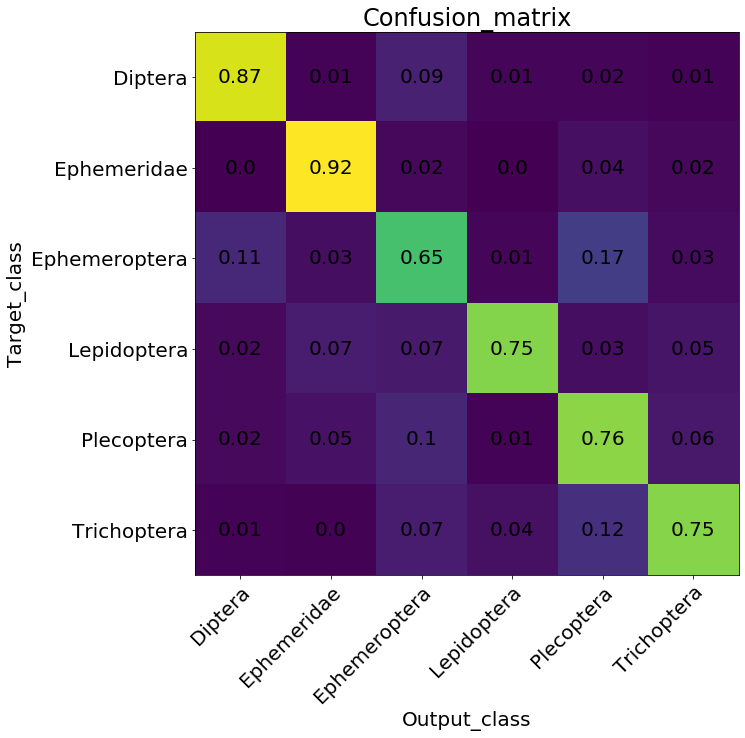

In [13]:
create_confusion_matrix(validation_matrix, ntests, args.labels, args.figure_root, save=args.save_fig)

In [14]:
each_df = compute_each_size_df(result, x_all, y_all)
if args.save_df is True:
    each_df.to_csv(pj(args.figure_root, "each_size_df.csv"))
each_df

,Accuracy,Insect_size
0,True,5632
1,True,13125
2,True,12190
3,True,4148
4,True,323
...,...,...
1277,True,3360
1278,False,1539
1279,True,3408
1280,False,798


In [15]:
all_df = compute_all_size_df(each_df)
if args.save_df is True:
    all_df.to_csv(pj(args.figure_root, "all_size_df.csv"))
all_df

,order,Accuracy,Insect_size
0,1.0,0.000000,2.000000
1,7.0,0.900000,208.900000
2,8.0,0.860465,400.651163
3,9.0,0.596330,778.706422
4,10.0,0.663755,1510.864629
5,11.0,0.742958,2949.616197
6,12.0,0.883495,5938.822006
7,13.0,0.923445,11264.789474
8,14.0,0.692308,22344.653846
9,15.0,0.800000,34865.400000


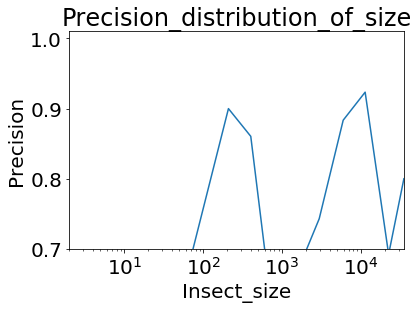

In [16]:
plot_df_distrib_size(all_df, args.figure_root, save=args.save_fig)